In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

$\frac{dU}{dt} + U\frac{dU}{dx} = 0\\
\frac{dU}{dt} + U\frac{dU}{dx} = \frac{d^2U}{dx^2}$

$\frac{dU}{dt} + \frac{dflux(U)}{dx} = dissipation(U)$

In [3]:
def flux(U):
    return 0.5 * U ** 2
def dissipation(U, h):
    U_n = np.zeros_like(U)
    U_n[1:-1] = (U[2:] - 2. * U[1:-1] + U[:-2]) / h ** 2
    U_n[0] = U_n[1]
    U_n[-1] = U_n[-2]
    return U_n

In [4]:
# space-derivative approximation functions

#def right_1(U, h):
#    return (flux(U)[1:] - flux(U)[:-1]) / h, 1, None
#def right_2(U, h):
#    return (flux(U)[0:-2] - 4 * flux(U)[1:-1] + 3 * flux(U)[2:]) / h / 2., 2, None
def central_2(U, h, nu):
    return -U[1:-1] * (U[2:] - U[:-2]) / 2. / h + nu * dissipation(U, h)[1:-1], 1, -1
def central_4(U, h, nu):
    return -U[2:-2] * (U[:-4] - U[4:] + 8. * (U[3:-1] - U[1:-3])) / 12. / h + nu * dissipation(U, h)[2:-2], 2, -2
def central_6(U, h, nu):
    return -U[3:-3] * (U[6:] - U[:-6] + 9. * (U[1:-5] - U[5:-1]) + 45. * (U[4:-2] - U[2:-4])) / 60. / h + nu * dissipation(U, h)[3:-3], 3, -3
def weno_5(U, h, nu):
    N = U.size
    C = np.array([[1./3., 5./6., -1./6.],
                  [-1./6., 5./6., 1./3.],
                  [1./3., -7./6., 11./6.]])
    C_wave = C[::-1, ::-1]
    Beta = np.zeros((3, N - 6))
    Beta[0, :] = 13./12. * (U[3:-3] - 2. * U[4:-2] + U[5:-1]) ** 2 + 1./4. * (3. * U[3:-3] - 4. * U[4:-2] + U[5:-1]) ** 2
    Beta[1, :] = 13./12. * (U[2:-4] - 2. * U[3:-3] + U[4:-2]) ** 2 + 1./4. * (U[2:-4] - U[4:-2]) ** 2
    Beta[2, :] = 13./12. * (U[1:-5] - 2. * U[2:-4] + U[3:-3]) ** 2 + 1./4. * (U[1:-5] - 4. * U[2:-4] + 3. * U[3:-3]) ** 2
    Beta_wave = Beta[::-1, ::-1]
    
    d = np.array([0.3, 0.6, 0.1])
    d_wave = d[::-1]
    eps = 1e-20
    alpha = d / (eps + Beta.T) ** 2
    alpha_wave = d_wave / (eps + Beta_wave.T) ** 2
    W = alpha.T / np.sum(alpha, axis = 1)
    W_wave = alpha_wave.T / np.sum(alpha_wave, axis = 1)
    
    U_R = np.copy(U)
    U_L = np.copy(U)

    U_R[3:-3] += W[0, :] * np.convolve(U[3:-1], C[0, ::-1], 'valid') + \
                 W[1, :] * np.convolve(U[2:-2], C[1, ::-1], 'valid') + \
                 W[2, :] * np.convolve(U[1:-3], C[2, ::-1], 'valid')
    U_L[3:-3] += W_wave[0, :] * np.convolve(U[3:-1], C_wave[0, ::-1], 'valid') + \
                 W_wave[1, :] * np.convolve(U[2:-2], C_wave[1, ::-1], 'valid') + \
                 W_wave[2, :] * np.convolve(U[1:-3], C_wave[2, ::-1], 'valid')
    
    U_big = np.zeros(len(U) + 1)
    U_big[0] = U_L[0]
    U_big[-1] = U_R[-1]
    S = 0.5 * (U_L[1:] + U_R[:-1])
    U_big[1:-1][S > 0] = U_R[:-1][S > 0]
    U_big[1:-1][S < 0] = U_L[1:][ S < 0]
    U_big[1:-1][S == 0] = 0
    Flux = -0.5 * (U_big[1:] ** 2 - U_big[:-1] ** 2) / h + nu * dissipation(U, h)
    return Flux, 0, None

In [5]:
# time-derivative approximation functions

def runge_kutta_7(U, h, r, Deriv, nu):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    k5 = np.zeros_like(U)
    k6 = np.zeros_like(U)
    k7 = np.zeros_like(U)
    k8 = np.zeros_like(U)
    k9 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h, nu)
    k1[idx_l:idx_r] = temp1
    temp2, idx_l, idx_r = Deriv(U + dt * k1  / 6.0, h, nu)
    k2[idx_l:idx_r] = temp2
    temp3, idx_l, idx_r = Deriv(U + dt * k2  / 3.0, h, nu)
    k3[idx_l:idx_r] = temp3
    temp4, idx_l, idx_r = Deriv(U + dt * k1  / 8.0 + dt * k3 * 3.0  / 8.0, h, nu)
    k4[idx_l:idx_r] = temp4
    temp5, idx_l, idx_r = Deriv(U + dt * k1 * 148.0  / 1331.0 + dt * k3 * 150.0  / 1331.0 - dt * k4 * 56.0  / 1331.0, h, nu)
    k5[idx_l:idx_r] = temp5
    temp6, idx_l, idx_r = Deriv(U - dt * k1 * 404.0  / 243.0 - dt * k3 * 170.0  / 27.0 + dt * k4 * 4024.0  / 1701.0 + dt * k5 * 10648.0  / 1701.0, h, nu)
    k6[idx_l:idx_r] = temp6
    temp7, idx_l, idx_r = Deriv(U + dt * k1 * 2466.0  / 2401.0 + dt * k3 * 1242.0  / 343.0 - dt * k4 * 19176.0  / 16807.0 - dt * k5 * 51909.0  / 16807.0 + dt * k6 * 1053.0  / 2401.0, h, nu)
    k7[idx_l:idx_r] = temp7
    temp8, idx_l, idx_r = Deriv(U + dt * k1 * 5.0  / 154.0 + dt * k4 * 96.0  / 539.0 - dt * k5 * 1815.0  / 20384.0 - dt * k6 * 405.0  / 2464.0 + dt * k7 * 49.0  / 1144.0, h, nu)
    k8[idx_l:idx_r] = temp8
    temp9, idx_l, idx_r = Deriv(U - dt * k1 * 113.0  / 32.0 - dt * k3 * 195.0  / 22.0 + dt * k4 * 32.0  / 7.0 + dt * k5 * 29403.0  / 3584.0 - dt * k6 * 729.0  / 512.0 + dt * k7 * 1029.0  / 1408.0 + dt * k8 * 21.0  / 16.0, h, nu)
    k9[idx_l:idx_r] = temp9
    return U + dt * k4 * 32.0  / 105.0 + dt * k5 * 1771561.0  / 6289920.0 + dt * k6 * 243.0  / 2560.0 + dt * k7 * 16807.0  / 74880.0 + dt * k8 * 77.0  / 1440.0 + dt * k9 * 11.0  / 270.0, dt, 0, None

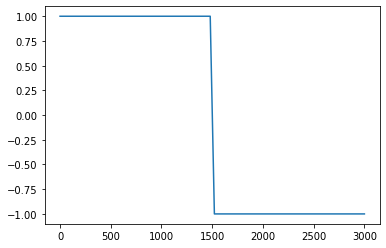

In [6]:
h = 0.5
L = 3000
r = 0.5
T = 10
nu = 0

Nx = int(L / h)
U = np.zeros(Nx)
x0 = int(Nx / 2) - int(20 / h)
x1 = x0 + int(40 / h)
U[:x0] = 1.
U[x1:] = -1.
for x in range(x0, x1):
    U[x] = 2. * x / (x0 - x1) + (1. - 2. * x0 / (x0 - x1))
x = np.linspace(0, L, Nx)
plt.plot(x, U)

In [7]:
temp, dt, idx_l, idx_r = runge_kutta_7(U, h, r, weno_5, nu)
U[idx_l : idx_r] = temp
#self.U = temp
Nt = int(T / dt)
for i in trange(Nt):
    if i == 0: continue
    temp, dt, idx_l, idx_r = runge_kutta_7(U, h, r, weno_5, nu)
    U[idx_l : idx_r] = temp

  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\dmdrf\AppData\Local\Temp/ipykernel_11924/2388187395.py:28: RuntimeWarning: overflow encountered in square
  alpha = d / (eps + Beta.T) ** 2
C:\Users\dmdrf\AppData\Local\Temp/ipykernel_11924/2388187395.py:29: RuntimeWarning: overflow encountered in square
  alpha_wave = d_wave / (eps + Beta_wave.T) ** 2
C:\Users\dmdrf\AppData\Local\Temp/ipykernel_11924/2388187395.py:30: RuntimeWarning: invalid value encountered in true_divide
  W = alpha.T / np.sum(alpha, axis = 1)
C:\Users\dmdrf\AppData\Local\Temp/ipykernel_11924/2388187395.py:31: RuntimeWarning: invalid value encountered in true_divide
  W_wave = alpha_wave.T / np.sum(alpha_wave, axis = 1)
C:\Users\dmdrf\AppData\Local\Temp/ipykernel_11924/2388187395.py:20: RuntimeWarning: overflow encountered in square
  Beta[0, :] = 13./12. * (U[3:-3] - 2. * U[4:-2] + U[5:-1]) ** 2 + 1./4. * (3. * U[3:-3] - 4. * U[4:-2] + U[5:-1]) ** 2
C:\Users\dmdrf\AppData\Local\Temp/ipykernel_11924/2388187395.py:21: R

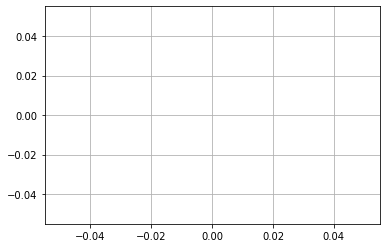

In [8]:

plt.plot(x[x0 - 100: x1 + 100], U[x0 - 100: x1 + 100])
plt.grid()